Copyright 2021 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This solution, including any related sample code or data, is made available 
on an “as is,” “as available,” and “with all faults” basis, solely for 
illustrative purposes, and without warranty or representation of any kind. 
This solution is experimental, unsupported and provided solely for your 
convenience. Your use of it is subject to your agreements with Google, as 
applicable, and may constitute a beta feature as defined under those 
agreements.  To the extent that you make any data available to Google in 
connection with your use of the solution, you represent and warrant that you 
have all necessary and appropriate rights, consents and permissions to permit 
Google to use and process that data.  By using any portion of this solution, 
you acknowledge, assume and accept all risks, known and unknown, associated 
with its usage, including with respect to your deployment of any portion of 
this solution in your systems, or usage in connection with your business, 
if at all.


# Setup

### Load modules

In [ ]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

!pip install fitter
import fitter
from fitter import Fitter, get_common_distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.4
     |████████████████████████████████| 47 kB 1.6 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=806a79383bee6506b0f811d8a946ad2e80708f6a62b83ac076d1e40a158eac34
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=77c8013c85b928d6da39d3a9ce250d39c480734913fd1965d154564c5b686d23
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


# Define Parameters

In [ ]:
#@title Parameters

INPUT_SHEET_NAME = 'model input data' #@param {type:"string"}


### Load model input data

In [ ]:
google_sheets_name = INPUT_SHEET_NAME #@param

In [ ]:
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

In [ ]:
df = df[['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts']]
         

In [ ]:
#df.fillna(0, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Brand_x_Core_x_NC_clicks             607 non-null    float64
 1   The_Trade_Desk_x_Audio_x_AWA_imps    607 non-null    float64
 2   DBM_x_Display_x_RTG_imps             607 non-null    float64
 3   Amazon_x_Display_x_AWA_imps          607 non-null    float64
 4   DBM_x_Video_x_AWA_imps               607 non-null    float64
 5   The_Trade_Desk_x_Display_x_AWA_imps  607 non-null    float64
 6   Brand_x_RMKT_x_EC_clicks             607 non-null    float64
 7   OTHER_x_Display_x_AWA_imps           607 non-null    float64
 8   Amazon_x_Display_x_RTG_imps          607 non-null    float64
 9   DBM_x_Display_x_ACQ_imps             607 non-null    float64
 10  Oath_x_Display_x_AWA_imps            607 non-null    float64
 11  DBM_x_Display_x_AWA_imps        

In [ ]:
KPI_COL = "new_accounts" #@param {type: "string"}

In [ ]:
df.sum()

0
Brand_x_Core_x_NC_clicks              286.00893   
The_Trade_Desk_x_Audio_x_AWA_imps     69.44837    
DBM_x_Display_x_RTG_imps              351.89009   
Amazon_x_Display_x_AWA_imps           89.03111    
DBM_x_Video_x_AWA_imps                78.80941    
The_Trade_Desk_x_Display_x_AWA_imps   42.63087    
Brand_x_RMKT_x_EC_clicks              171.95582   
OTHER_x_Display_x_AWA_imps            172.37993   
Amazon_x_Display_x_RTG_imps           129.33795   
DBM_x_Display_x_ACQ_imps              114.26229   
Oath_x_Display_x_AWA_imps             100.46011   
DBM_x_Display_x_AWA_imps              133.70946   
new_accounts                          910963.00000
dtype: float64

In [ ]:
df.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,0.47118,0.11441,0.57972,0.14667,0.12983,0.07023,0.28329,0.28399,0.21308,0.18824,0.16550,0.22028,1500.76277
std,0.16844,0.15197,0.20971,0.22154,0.15098,0.17215,0.20413,0.27005,0.25665,0.18653,0.22315,0.24301,459.59147
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,365.00000
25%,0.35525,0.00000,0.51710,0.00000,0.00000,0.00000,0.12363,0.06260,0.00000,0.09887,0.00000,0.03567,1174.00000
50%,0.46720,0.05341,0.61904,0.03434,0.08333,0.00000,0.21037,0.15580,0.00000,0.13576,0.00000,0.13662,1478.00000
75%,0.58713,0.19618,0.70289,0.23873,0.22359,0.00000,0.41195,0.49225,0.41618,0.21503,0.29745,0.28018,1697.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3011.00000


In [ ]:
df.new_accounts.sum()

910963

In [ ]:
y = df[KPI_COL]
x = df[df.columns[df.columns != KPI_COL]]

In [ ]:
df['Intercept'] = 1
df.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts',
       'Intercept'],
      dtype='object', name=0)

In [ ]:
x.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps'],
      dtype='object', name=0)

## Bayesian Model

In [ ]:
with pm.Model() as linear_model:


    ## OPTION: Set prior distributions individually

    
    #This code sets flat priors by default, but it is recommended to create more informative priors depending on use case

    # Intercept
    intercept = pm.HalfFlat('Intercept')
    
    # Beta parameters
      # Use this loop if you want to set all coefficients to the same prior distribution
    for z in range(1, len(x.columns)+1):
      locals()['beta%s' % z] = pm.HalfFlat('beta%s' % z)
    
    # Or set individual priors
    #beta1 = pm.Uniform('beta1')


    # Standard deviation
      #Can only be positive, thus has to take on a halfnormal dist.
    sigma = pm.HalfNormal('sigma', sd = y.std()) 


    ## SET UP FORMULA TO ESTIMATE 
    # Estimate of mean
    mean = intercept + (beta1 *x['Brand_x_Core_x_NC_clicks']) + (beta2 *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (beta3 *x['DBM_x_Display_x_RTG_imps']) + (beta4 *x['Amazon_x_Display_x_AWA_imps']) + (beta5 *x['DBM_x_Video_x_AWA_imps']) + (beta6 *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (beta7 *x['Brand_x_RMKT_x_EC_clicks']) + (beta8 *x['OTHER_x_Display_x_AWA_imps']) + (beta9 *x['Amazon_x_Display_x_RTG_imps']) + (beta10 *x['DBM_x_Display_x_ACQ_imps']) + (beta11 *x['Oath_x_Display_x_AWA_imps']) + (beta12 *x['DBM_x_Display_x_AWA_imps']) 


    ## SPECIFY LIKELIHOOD
    likelihood = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    ## observed data can be drawn from a distribution with mean "mu" and variance "sigma"
    

    # SAMPLE FROM THE POSTERIOR DISTRIBUTION
    normal_trace = pm.sample(return_inferencedata=True)
    model_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.


In [ ]:
normal_trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables: (12/14)
    Intercept  (chain, draw) float64 275.8 348.4 305.6 ... 359.0 330.4 350.8
    beta1      (chain, draw) float64 1.682e+03 1.597e+03 ... 1.735e+03 1.531e+03
    beta2      (chain, draw) float64 26.26 6.499 28.87 ... 3.24 5.618 4.059
    beta3      (chain, draw) float64 373.3 342.4 298.8 ... 331.3 322.1 353.9
    beta4      (chain, draw) float64 519.5 453.2 480.0 ... 358.6 387.4 528.5
    beta5      (chain, draw) float64 170.0 194.1 181.2 ... 100.5 191.1 235.6
    ...         ...
    beta8      (chain, draw) float64 24.15 15.31 0.3272 ... 0.4023 0.3394 0.1042
    beta9      (chain, draw) float64 8.67 25.57 4.476 ... 46.91 6.424 60.93
    beta10     (chain, draw) float64 15.69 8.402 9.727 ... 67.53 18.38 19.36
    beta11     (chain, draw) float64 182.9 224.0 151.7 ... 85.97 109.8 301.7
    beta12     (chain, draw) float64 3.234 8.542 4.93 ... 7.411 7.406 2.975
    sigma      (chain, draw) float64 275.3 283.2 278.6 ... 272.5 289.2 269.1
Attributes:
    created_at:                 2021-09-22T20:42:10.946508
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              59.88830637931824
    tuning_steps:               1000

### Results and Evaluation

#### Posterior Predictive Checks

In [ ]:
with linear_model:
  post_pred = pm.sample_posterior_predictive(normal_trace.posterior)
az.concat(normal_trace, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


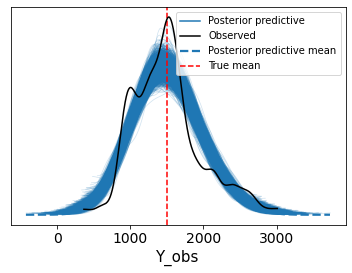

In [ ]:
# draws *  #  chains = 2000
# plots simulated datasets against the observed data
fig, ax = plt.subplots()
az.plot_ppc(normal_trace, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

#### Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb269c35b50>,
      dtype=object)

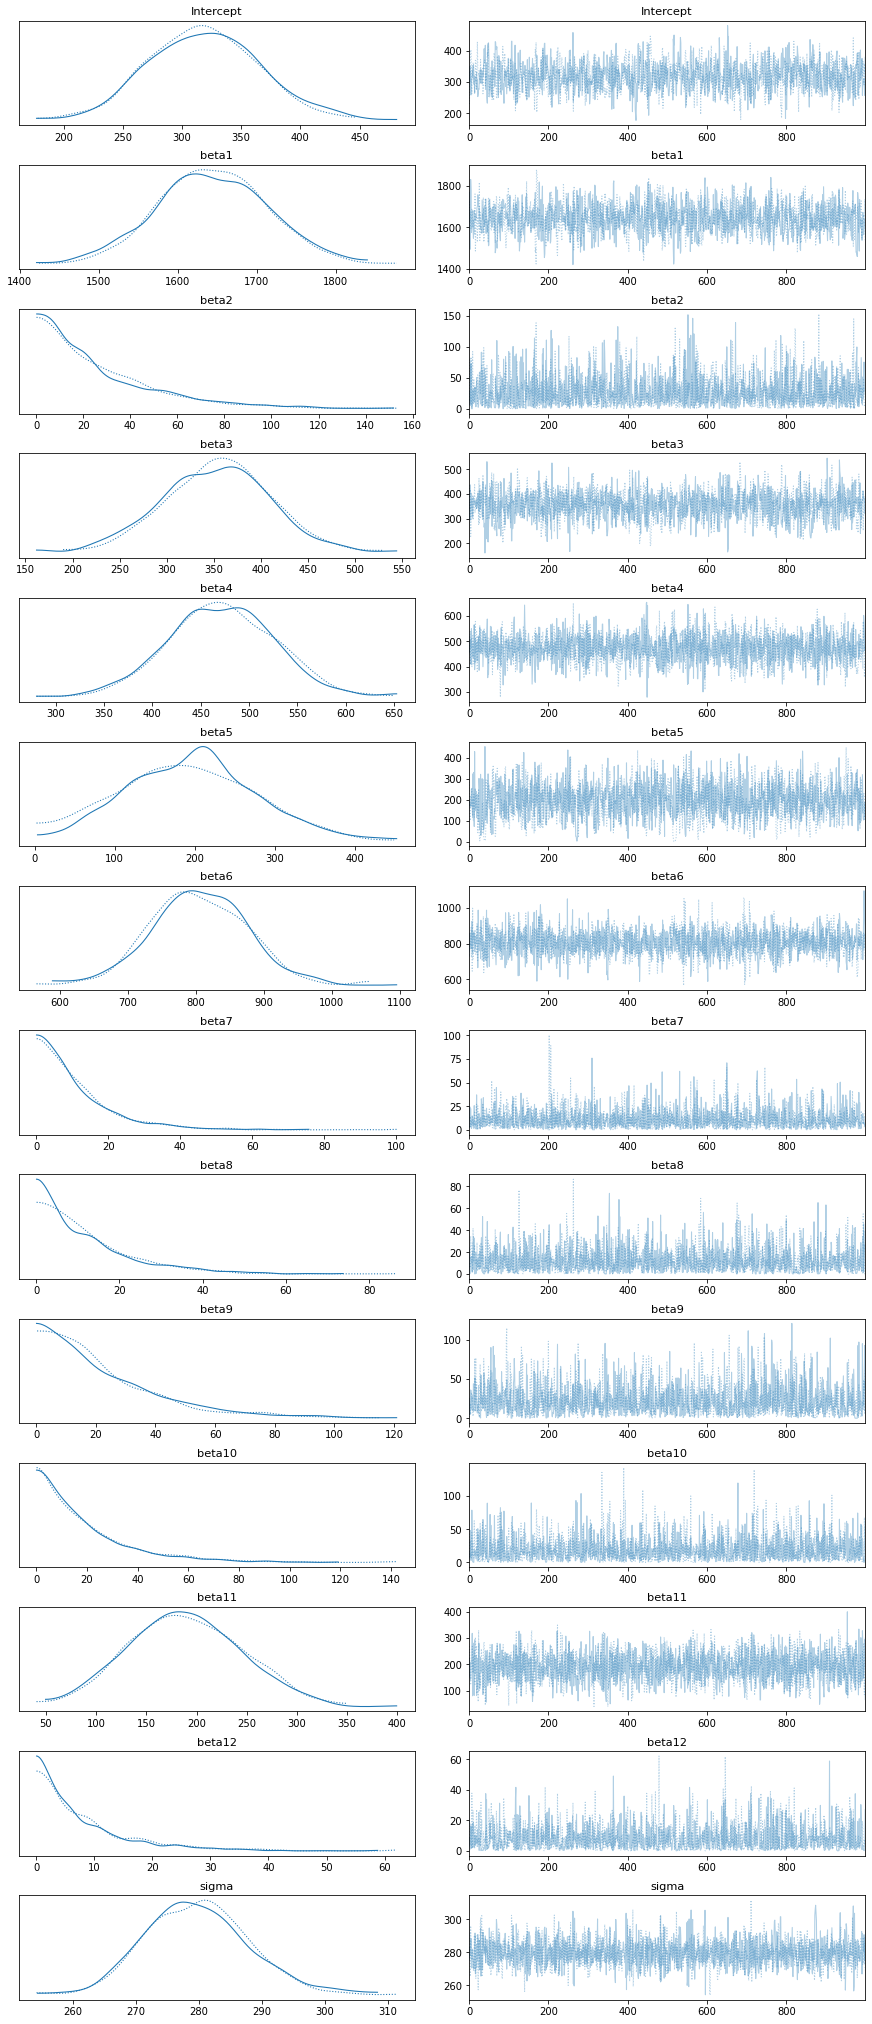

In [ ]:
az.plot_trace(normal_trace)

#### Posterior Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb25bae6610>,
      dtype=object)

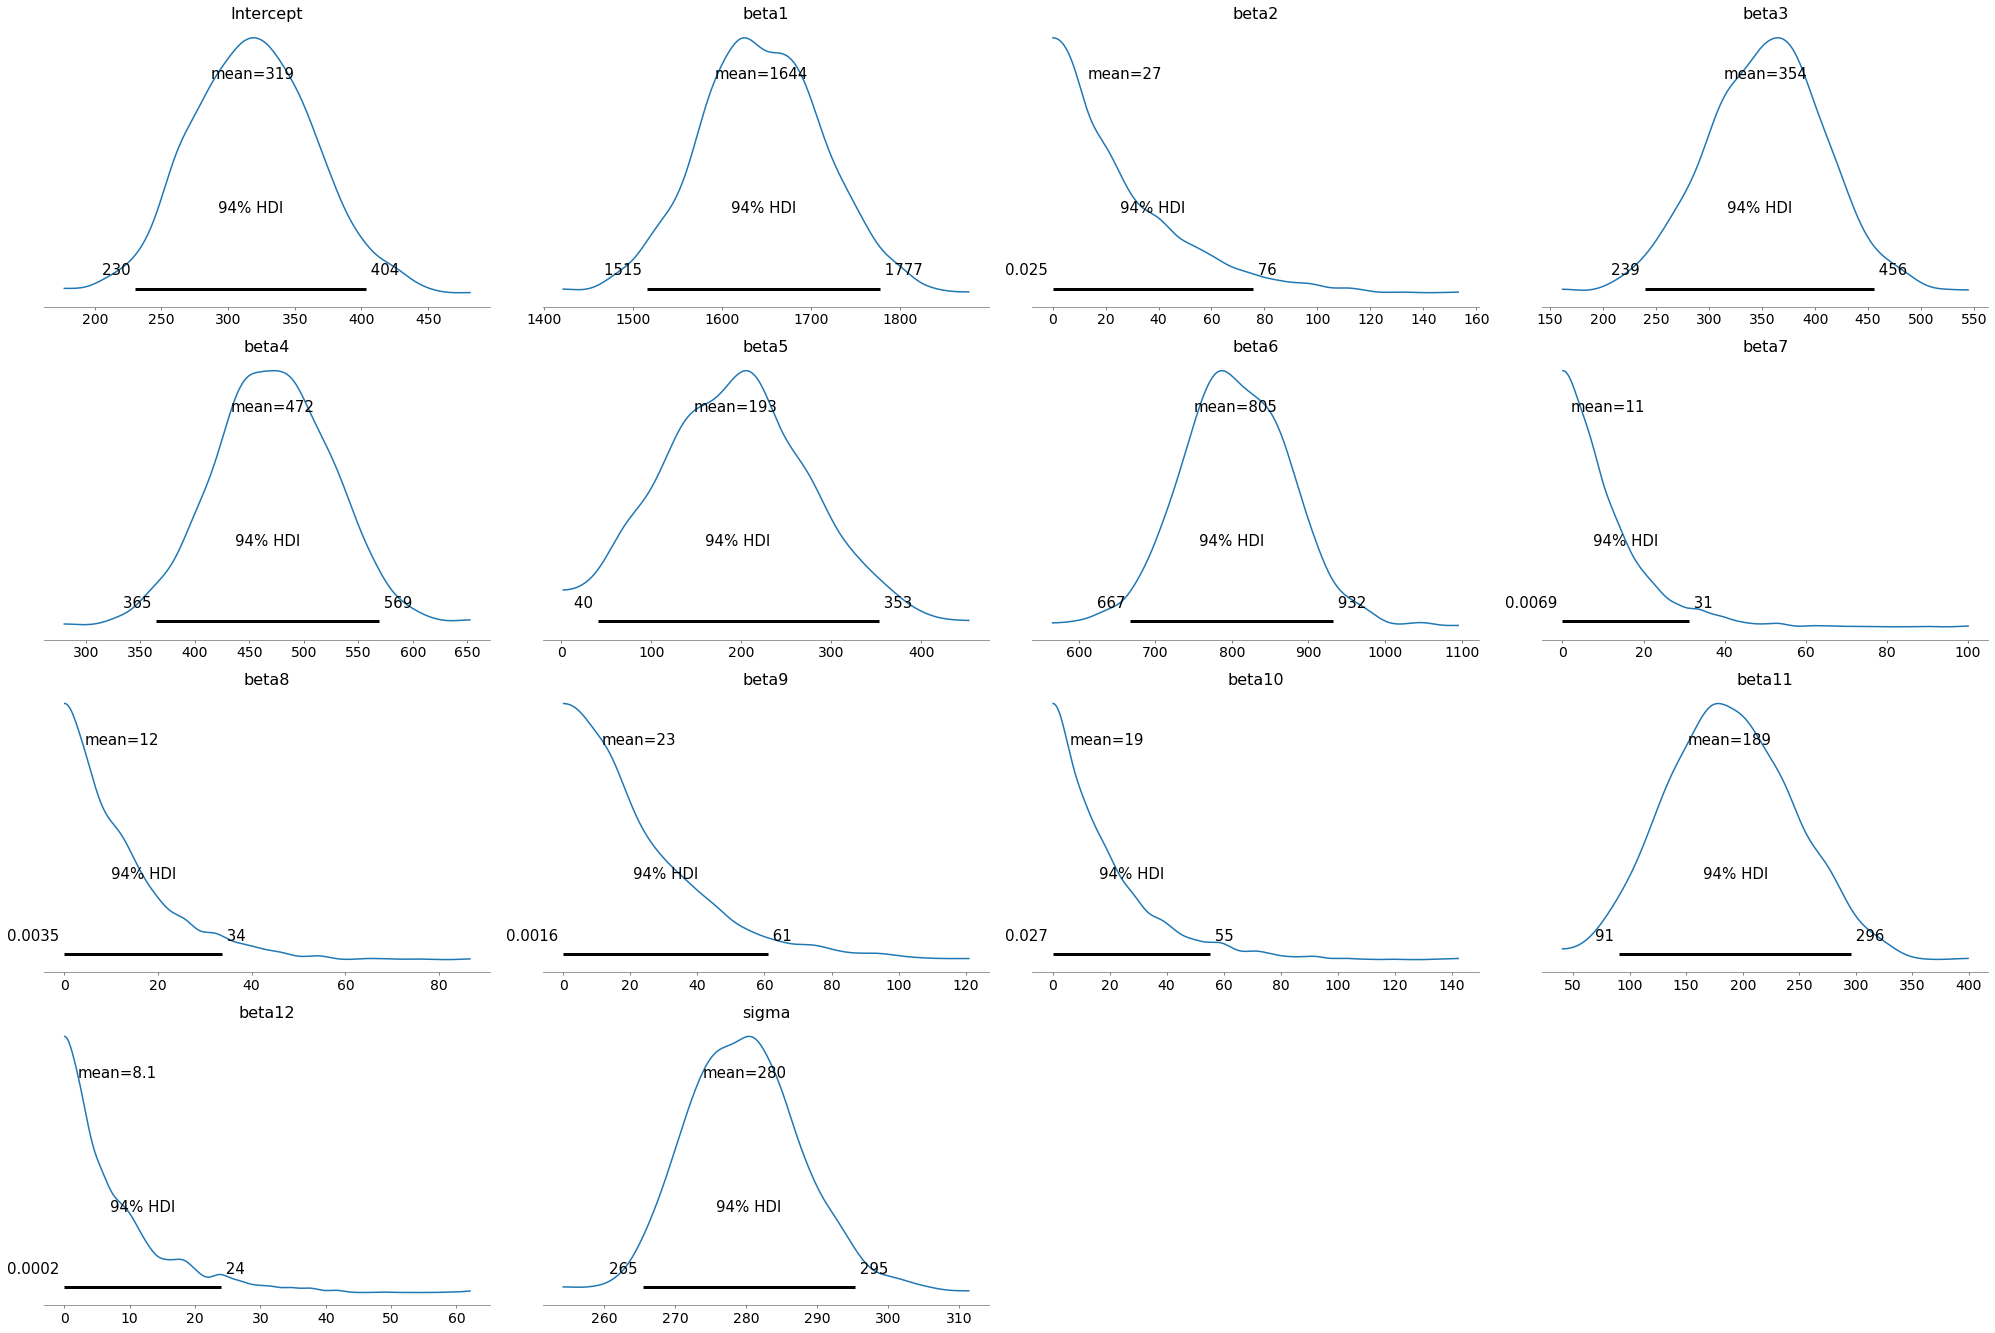

In [ ]:
az.plot_posterior(normal_trace)

#### Forest Plot

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb25a6a4f90>,
      dtype=object)

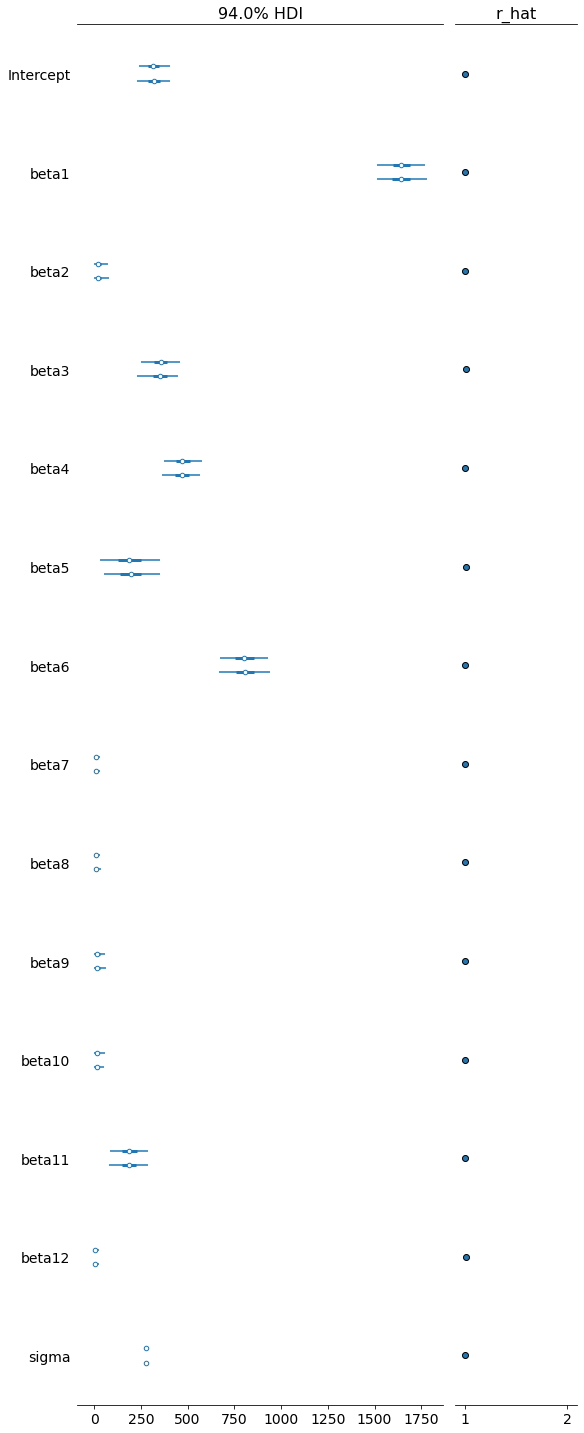

In [ ]:
az.plot_forest(normal_trace, r_hat = True)

#### Summary Statistics

In [ ]:
pm.summary(normal_trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,318.53000,46.15900,230.44200,403.51000,1.30400,0.93000,1253.00000,1282.00000,1.00000
beta1,1644.01300,69.77300,1515.05300,1777.11600,1.79800,1.27200,1498.00000,1074.00000,1.00000
beta2,27.29900,25.53700,0.02500,75.50900,0.54900,0.44500,1679.00000,890.00000,1.00000
beta3,353.64300,57.23500,239.11700,455.82600,1.43200,1.01300,1610.00000,1132.00000,1.00000
beta4,471.76300,55.03200,364.56100,568.56500,1.16100,0.82100,2237.00000,1483.00000,1.00000
beta5,193.33800,83.14400,40.48000,352.50200,2.27300,1.60700,1169.00000,548.00000,1.00000
beta6,805.16000,71.48900,667.04100,931.83300,1.57200,1.11200,2054.00000,1124.00000,1.00000
beta7,11.11000,10.76900,0.00700,31.20400,0.19000,0.15800,1872.00000,985.00000,1.00000
beta8,12.33900,11.54600,0.00400,33.68700,0.21700,0.16900,1703.00000,966.00000,1.00000
beta9,22.65100,20.12100,0.00200,60.92800,0.46500,0.33900,1404.00000,973.00000,1.00000


### Bayesian Evaluation Metrics and CV

#### BFMI

In [ ]:
pm.bfmi(normal_trace)

array([0.90985713, 0.88615477])

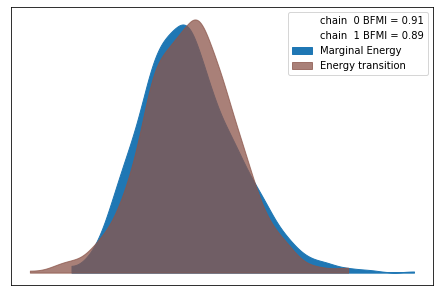

In [ ]:
az.plot_energy(normal_trace)

#### WAIC/LOO/ELPD

In [ ]:
pm.waic(normal_trace)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 607 log-likelihood matrix

          Estimate       SE
elpd_waic -4285.37    21.39
p_waic       10.15        -

There has been a warning during the calculation. Please check the results.

In [ ]:
pm.loo(normal_trace, pointwise = True)

Computed from 2000 by 607 log-likelihood matrix

         Estimate       SE
elpd_loo -4285.41    21.40
p_loo       10.19        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      607  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Error Metrics

Obtain the average parameter estimates

In [ ]:
var_dict = {}
for variable in model_trace.varnames:
  var_dict[variable] = model_trace[variable]
  
# Results into a dataframe
var_weights = pd.DataFrame(var_dict)
var_weights.drop(columns = ['Intercept_log__','beta1_log__','beta2_log__','beta3_log__','beta4_log__','beta5_log__','beta6_log__','beta7_log__','beta8_log__','beta9_log__','beta10_log__', 'beta11_log__', 'beta12_log__','sigma_log__', 'sigma'], inplace = True)
# Means for all the weights
var_means = var_weights.mean(axis=0)

In [ ]:
var_means

Intercept   321.58764 
beta1       1641.43297
beta2       25.57976  
beta3       350.66344 
beta4       471.41344 
beta5       198.38089 
beta6       803.36331 
beta7       11.38195  
beta8       11.94152  
beta9       22.39659  
beta10      19.46995  
beta11      188.45172 
beta12      8.36298   
dtype: float64

In [ ]:
x['Intercept'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create predictions using the average parameter estimates

In [ ]:
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['Brand_x_Core_x_NC_clicks']) + (var_means['beta2'] *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (var_means['beta3'] *x['DBM_x_Display_x_RTG_imps']) + (var_means['beta4'] *x['Amazon_x_Display_x_AWA_imps']) + (var_means['beta5'] *x['DBM_x_Video_x_AWA_imps']) + (var_means['beta6'] *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (var_means['beta7'] *x['Brand_x_RMKT_x_EC_clicks']) + (var_means['beta8'] *x['OTHER_x_Display_x_AWA_imps']) + (var_means['beta9'] *x['Amazon_x_Display_x_RTG_imps']) + (var_means['beta10'] *x['DBM_x_Display_x_ACQ_imps']) + (var_means['beta11'] *x['Oath_x_Display_x_AWA_imps']) + (var_means['beta12'] *x['DBM_x_Display_x_AWA_imps']) 


In [ ]:
residuals = Y_pred - y

#### MAE

In [ ]:
mean_absolute_error(y,Y_pred)

217.57401593232981

#### MSE

In [ ]:
mean_squared_error(y,Y_pred)

76979.30706690169

#### RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(y,Y_pred))
rmse

277.4514499275534

#### R-Squared

In [ ]:
az.r2_score(y, Y_pred)[0]

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py (507)

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 507:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 508:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in data:


0.637285315583179

### Calculate % Effect

In [ ]:
print(round(100*(var_means['Intercept']*(x['Intercept']/Y_pred)).mean()))
print(round(100*(var_means['beta1']*(x['Brand_x_Core_x_NC_clicks']/Y_pred)).mean()))
print(round(100*(var_means['beta2']*(x['The_Trade_Desk_x_Audio_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta3']*(x['DBM_x_Display_x_RTG_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta4']*(x['Amazon_x_Display_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta5']*(x['DBM_x_Video_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta6']*(x['The_Trade_Desk_x_Display_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta7']*(x['Brand_x_RMKT_x_EC_clicks']/Y_pred)).mean()))
print(round(100*(var_means['beta8']*(x['OTHER_x_Display_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta9']*(x['Amazon_x_Display_x_RTG_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta10']*(x['DBM_x_Display_x_ACQ_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta11']*(x['Oath_x_Display_x_AWA_imps']/Y_pred)).mean()))
print(round(100*(var_means['beta12']*(x['DBM_x_Display_x_AWA_imps']/Y_pred)).mean()))


# Validate Linear Regression Model Assumptions

####1. Linearity

Visually inspect linearity between target variable and predictions

In [ ]:
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['Brand_x_Core_x_NC_clicks']) + (var_means['beta2'] *x['The_Trade_Desk_x_Audio_x_AWA_imps']) + (var_means['beta3'] *x['DBM_x_Display_x_RTG_imps']) + (var_means['beta4'] *x['Amazon_x_Display_x_AWA_imps']) + (var_means['beta5'] *x['DBM_x_Video_x_AWA_imps']) + (var_means['beta6'] *x['The_Trade_Desk_x_Display_x_AWA_imps']) + (var_means['beta7'] *x['Brand_x_RMKT_x_EC_clicks']) + (var_means['beta8'] *x['OTHER_x_Display_x_AWA_imps']) + (var_means['beta9'] *x['Amazon_x_Display_x_RTG_imps']) + (var_means['beta10'] *x['DBM_x_Display_x_ACQ_imps']) + (var_means['beta11'] *x['Oath_x_Display_x_AWA_imps']) + (var_means['beta12'] *x['DBM_x_Display_x_AWA_imps']) 


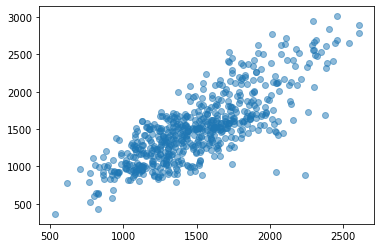

In [ ]:
plt.plot(Y_pred,y,'o',alpha=0.5)
plt.show()

#### 2. Normality of Errors

Visually inspect the residuals to confirm normality

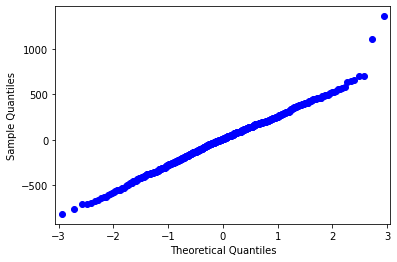

In [ ]:
fig = sm.qqplot(residuals)

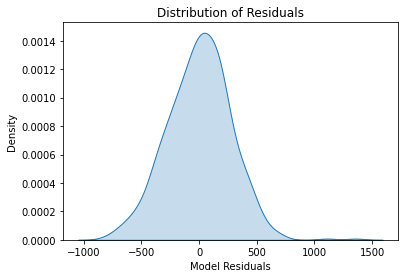

In [ ]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

####3. Absence of Multicollinearity

Tested and checked during data processing stage

####4. Homoscedasticity


Visually inspect residuals to confirm constant variance

In [ ]:
residuals.mean()

-0.13732422311434736

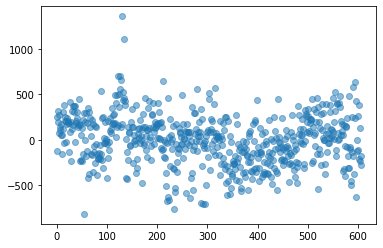

In [ ]:
plt.plot(residuals,'o',alpha=0.5)
plt.show()

# Appendix

## Parameterization Help

Use the `fitter` package to auto-detect the probability distribution of your data

In [ ]:
'''
sns.kdeplot(x[x.columns[3]], label = '', shade = True)
plt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');

f = Fitter(x[x.columns[2]],
           distributions= get_common_distributions())
f.fit()
f.summary()

f.get_best(method = 'aic')
f.fitted_param['uniform']
'''